# Sharks attack

### Visualization of the dataset

Now we are going to visualize the cleaned results in order to begin with the analysis. First we load the libraries and the clean dataset (that we cleaned in the data-clean notebook).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

sharks = pd.read_csv("../shark-attack/attacks_clean.csv", index_col=0, encoding = "ISO-8859-1")

First, we plot the year distribution of the shark attack inputs. We choose different bins and different year ranges for a better visualization.

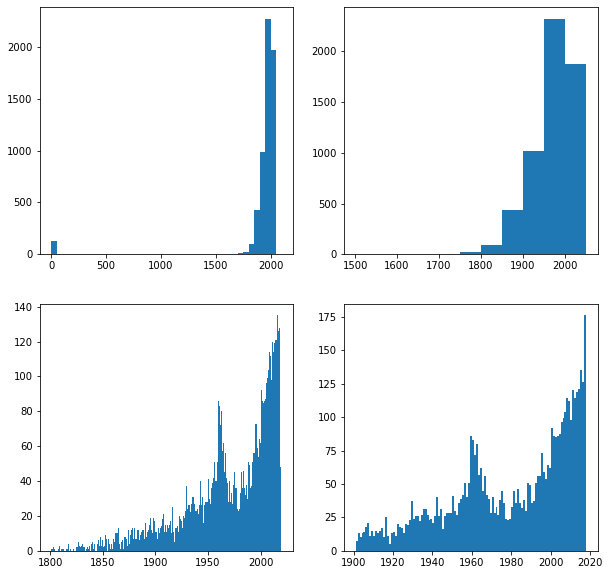

In [2]:
plt.figure(figsize=(10,10))
plt.subplot( 2,2, 1)
bins_y=np.arange(0, 2051 + 50, 50)
plt.hist(sharks["Year"],bins=bins_y)
plt.subplot( 2,2, 2)
bins_y=np.arange(1501, 2051 + 50, 50)
plt.hist(sharks["Year"],bins=bins_y)
plt.subplot( 2,2, 3)
bins_y=np.arange(1801, 2021)
plt.hist(sharks["Year"],bins=bins_y)
plt.subplot( 2,2, 4)
bins_y=np.arange(1901, 2019)
plt.hist(sharks["Year"],bins=bins_y)
plt.show()

There is a spike of sharks attack roughly in the year ~1960. At this time, it was subject of a scientific paper due to a rapid increase.

https://science.sciencemag.org/content/134/3472/87

Nevertheles, the overall trend besides this spike, is an uniform increment of the reoprting of shark related incidents. The majority of the reports are from the XIX, XX centuries and the ones of the XXI until 2018 (528, 3341 and 1878, respectively). This might be explained to more capacity of gathering information with time.

We are going to work only with the ones from the XIX-XXI centirues, in order to work with more reliable information. 

In [3]:
sharks = sharks[sharks["Year"] >= 1801]

In [4]:
sharks[(sharks["Year"] >=1801) & (sharks["Year"] < 1901)].shape

(528, 20)

In [5]:
sharks[(sharks["Year"] >=1901) & (sharks["Year"] < 2001)].shape

(3341, 20)

In [6]:
sharks[sharks["Year"] >=2001].shape

(1878, 20)

The distributions of the type of incidents is shown in the figure just below. The vast majority of the shark attaks are unprovoked (4442), followed by provoked incidents (565), sailing related (337) and disasters (228). There are only 175 events without proper identifiction. 

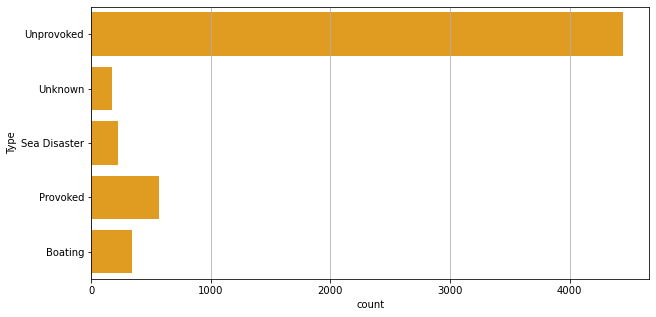

In [7]:
plt.figure(figsize=(10,5))
types = sharks["Type"].dropna().sort_values(ascending=False).unique()
plt.grid(True)
sns.countplot(y=(sharks["Type"]),color="orange",order=types)
plt.show()

In [8]:
sharks["Type"].value_counts()

Unprovoked      4442
Provoked         565
Boating          337
Sea Disaster     228
Unknown          175
Name: Type, dtype: int64

Now we are going to plot the fatal events in relation with the type of incident. The ones with higher fatal rate are the sea disasters, followed by the unprovoked incidents. The rest of the incidents are not normally fatal, even the proviked ones.

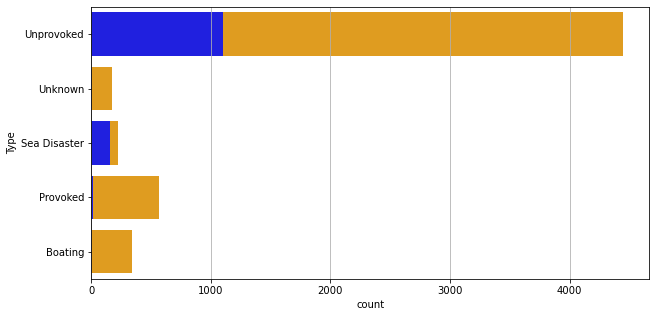

In [9]:
plt.figure(figsize=(10,5))
plt.grid(True)
sns.countplot(y="Type", data=sharks,color="orange",order=types)
sns.countplot(y="Type", data=sharks[sharks["Fatal"] == "Y"],color="blue",order=types)
plt.show()

There is a clearly skewed gender distribution of the attacks. The vast majority of the people involved in sharks attacks are men.

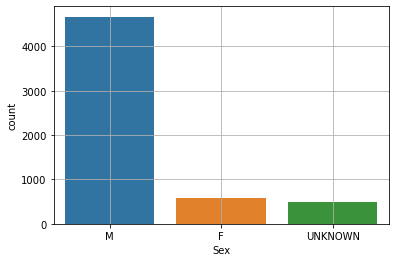

In [10]:
sns.countplot(x="Sex", data=sharks,order=["M","F","UNKNOWN"])
plt.grid(True)
plt.show()

The distribution of attacks through the year is not the same, as they are more frequent in the north hemisphere's summer.

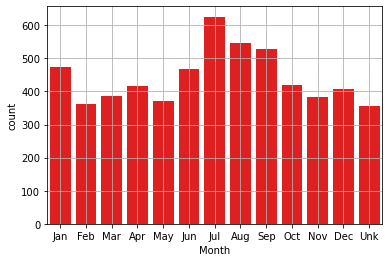

In [11]:
order_months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Unk"]
sns.countplot(x="Month", data=sharks,color="red",order=order_months)
plt.grid(True)
plt.show()

The countries where the shark attacks are more commin are the United States, Australia and South Africa, in that order. For the rest of the countries there are reported rougly 100 caser or less. Below we represent the top-10 countries

In [12]:
countries = sharks["Country"].value_counts().sort_values(ascending=False)
countries[:10]

USA                 2060
AUSTRALIA           1237
SOUTH AFRICA         522
PAPUA NEW GUINEA     128
NEW ZEALAND          120
BAHAMAS              104
BRAZIL               104
MEXICO                83
FIJI                  61
ITALY                 60
Name: Country, dtype: int64

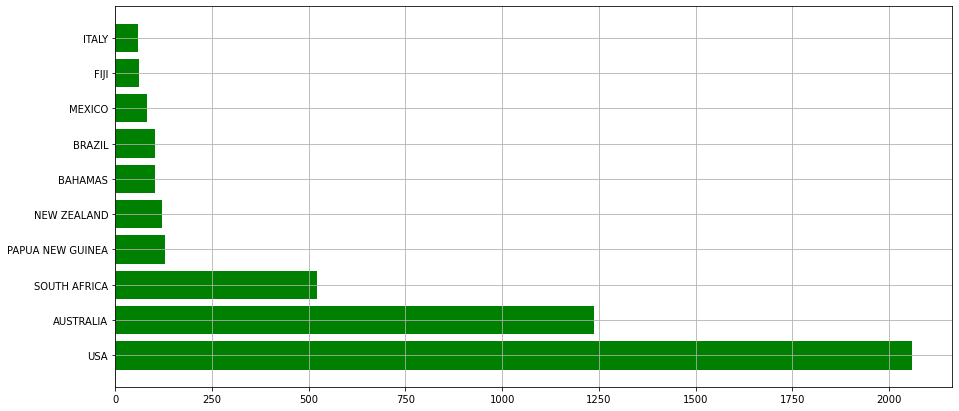

In [13]:
plt.figure(figsize=(15,7))
plt.grid(True)
plt.barh(countries[0:10].index,countries[0:10].values, color="green")
plt.show()

For almost all of the shark attacks, we do not have species information. Among the fraction that we know which species are involved, the most common are the white, tiger and bull sharks. The rest of the species have less than 100 incidents for each one.

In [14]:
species = sharks["Species"].value_counts().sort_values(ascending=False)
species[:11]

Unknown          3851
White             658
Tiger             280
Bull              172
Blacktip           74
Grey               64
Bronze whaler      63
Nurse              55
Mako               54
Blue               53
Wobbegong          50
Name: Species, dtype: int64

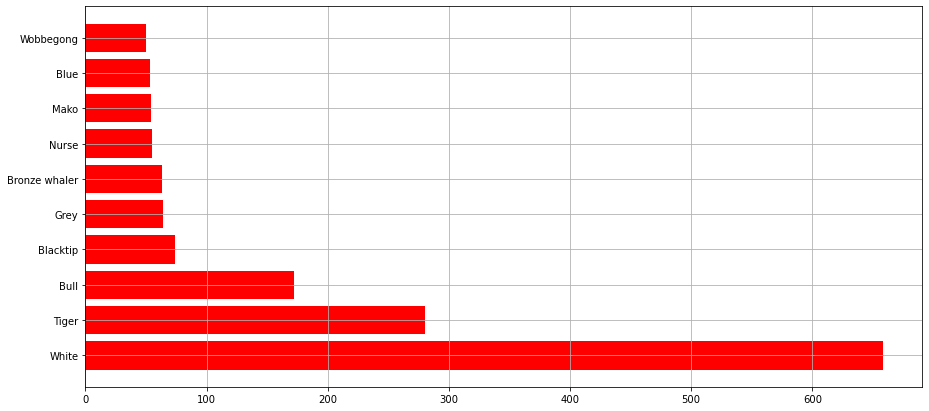

In [15]:
plt.figure(figsize=(15,7))
plt.grid(True)
plt.barh(species[1:11].index,species[1:11].values, color="red")
plt.show()

### Word frequency based analysis of the database

There are strings with information about each incident and the injuries related. The database is long enough to be hard to obtain broad information about what happend in the incidents.

My approach to the analysis is if, using the word frequency of the information listed in the database, we can learn about the nature of the shark attacks of each type category. 

To do so we create functions to obtain a dictionary of the word frequency of an input. We exclude common words (a,the,in...) to obtain the words that are going to help through the analysis. We also exclude some words that might not be informative in this case (as shark, water or sea)

In [16]:
def word_count(df):
    counts = dict()
    #Ignore common words without info
    common = ["the","in","a","&","for","to","of","on","shark","it","were","out",
              "at","by","water","from","into","/","his","her","he","she","men","as",
             "after","with","was","when","off","sea","and","or","but","down","sharks",
             "him","her","shark's","that","an","went","days","day","3","2","1"]
    
    for string_raw in df: 
        try:
            #Group related words that shows often
            string = string_raw.lower()
            string = string.replace("surfing","surf").replace("surfed","surf")
            string = string.replace("diving","dive").replace("diver","dive")
            string = string.replace("netting","net").replace("netted","net")
            string = string.replace("sank","sink").replace("sunk","sink").replace("sinking","sink")
            #Separate string into words and ignore punctuation
            words = string.replace(",","").replace(".","").replace(";","").split()
        except AttributeError:
            pass

        for word in words:
            if word in common:
                pass
            elif word in counts:
                counts[word] += 1
            else:
                counts[word] = 1

    return counts

def word_count_injuries(df):
    counts = dict()
    #Ignore common words without info
    common = ["the","in","a","&","for","to","of","on","shark","it","were","out","boat","as",
              "at","by","water","from","into","/","his","her","he","she","men","board","m","some",
             "after","with","was","when","off","sea","and","or","but","down","sharks","have",
             "him","her","shark's","that","an","went","days","day","3","2","1","no","not"]
    
    for string_raw in df: 
        try:
            #Group related words that shows often
            string = string_raw.lower()
            string = string.replace("surfing","surf").replace("surfed","surf")
            string = string.replace("diving","dive").replace("diver","dive")
            string = string.replace("netting","net").replace("netted","net")
            string = string.replace("bitted","bit").replace("bitten","bit").replace("bites","bit").replace("bite","bit")
            string = string.replace("netting","net").replace("netted","net")
            string = string.replace("sank","sink").replace("sunk","sink").replace("sinking","sink")
            string = string.replace("injured","injury")
            string = string.replace("lacerations","laceration").replace("lacerated","laceration")
            #Separate string into words and ignore punctuation
            words = string.replace(",","").replace('"',"").replace(".","").replace(";","").split()
        except AttributeError:
            pass

        for word in words:
            if word.lower() in common:
                pass
            elif word.lower() in counts:
                counts[word.lower()] += 1
            else:
                counts[word.lower()] = 1

    return counts

Now let's compute the word frequency of the sharks attack "Activity" column to measure and convert it to a Pandas series variable.

In [17]:
dic = word_count(sharks["Activity"])

activity_words = pd.Series( dic )

By sorting the frequency and obtaining the most repated words in the activity record, we obtain that the most common word is surfing, followed by swiming. In third position is fishing. 

The majority of the word are related with water activities (surfing, swimming, diving,...) and followed by fishing (fishing, spearfishing,...). These are the activities that are mosly related by shark incidents. There are other words related with sailing (boat, boarding,...) in the top 20 words.

In [18]:
activity_words=activity_words.sort_values(ascending=False)
activity_words[:20]

surf            1181
swimming        1095
fishing          757
dive             530
spearfishing     435
bathing          200
wading           173
standing         158
scuba            141
body             136
boat             136
boarding         131
snorkeling       103
free              99
overboard         98
fell              96
sink              72
fish              62
capsized          60
net               57
dtype: int64

To better visualize the results below we show a plot of the word frequency.

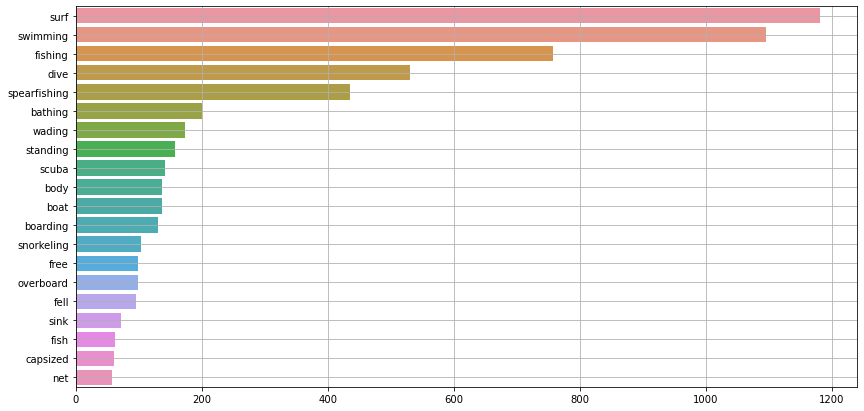

In [19]:
f, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x=activity_words[:20] ,y=activity_words[:20].index)
ax.grid(True)
plt.show()

Now we are going to do the same exercise dividing the word frequency analysis in different type of attacks:

- Unprovoked: As they are the vast majority of the cases, it is very similar to the overall data, but with less relative frequency of fishing related words.
- Unknown: The most frequent words are swimming, diving, spearfishing, surfing and fishing, as the main population but with different relative frequencies.
- Sea Disaster: These are more related to boat sanks and war events.
- Provoked: The most frequent words are related to fishing rather than vandalism as the name of the type could suggest.
- Boating: As in the prevous category, the most frequent word is fishing.

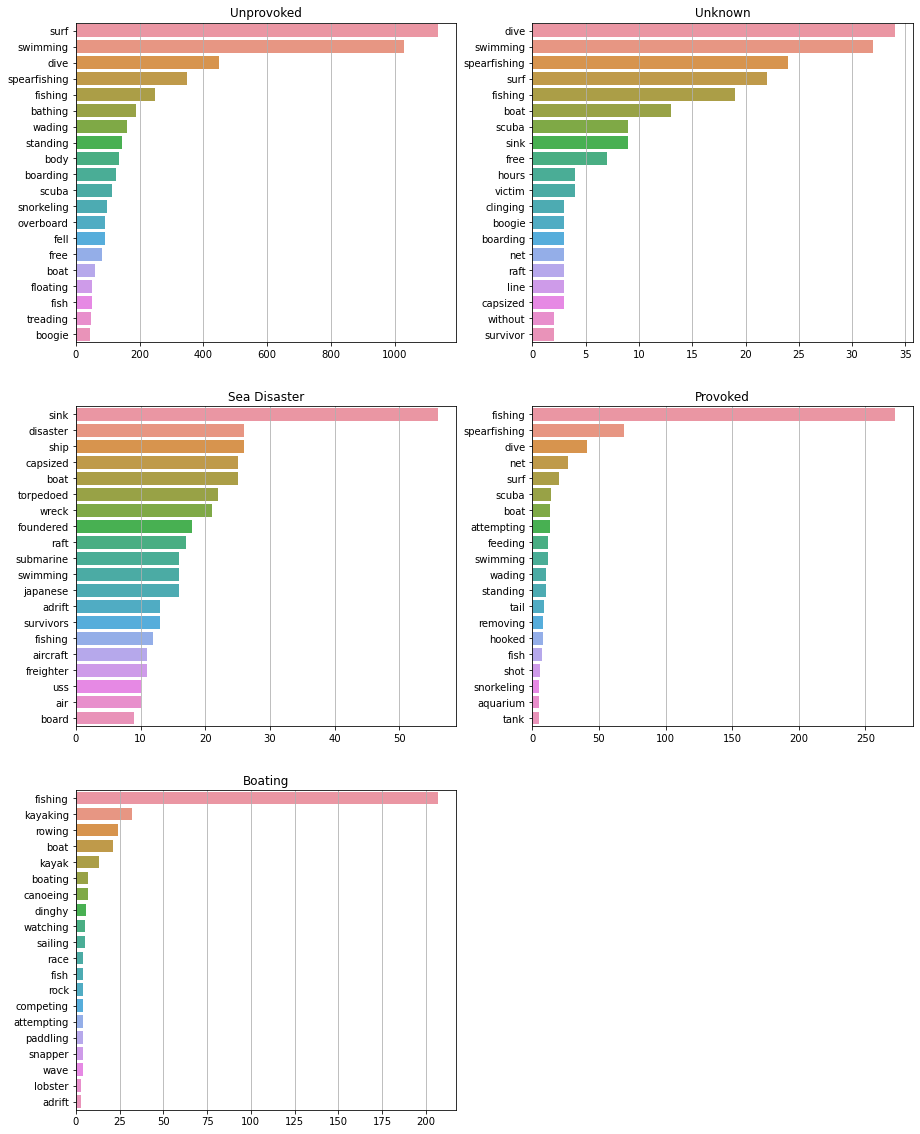

In [20]:
plt.figure(figsize=(15,20))
for i in range(len(types)):
    plt.subplot( len(types)//2+1,len(types)//2, i+1)
    plt.title(types[i])
    dic = word_count(sharks[sharks["Type"] == types[i]]["Activity"])
    injury_words = pd.Series( dic ).sort_values(ascending=False)
    plt.grid(True)
    sns.barplot(x=injury_words[:20] ,y=injury_words[:20].index)
plt.show()

The word frequency of the injuries report may be less informative as the activity one, but here are a few highlights of the analysis:

- In "Unprovoked" and "Sea Disaster" the word fatal appears more than in the rest. These are the categories that show more fatality ratio, so just having the word frequency we could have a hint of this information.
- In the "Unknown" category, among the most frequent words there are words as post-mortem, found, body, reported,.. that indicates that the origin of the shark incident is not clear because in many cases it may be reported afterwards the attack.
- In the "Sea Disaster" category, it is more often talked about survivors, crew, etc.


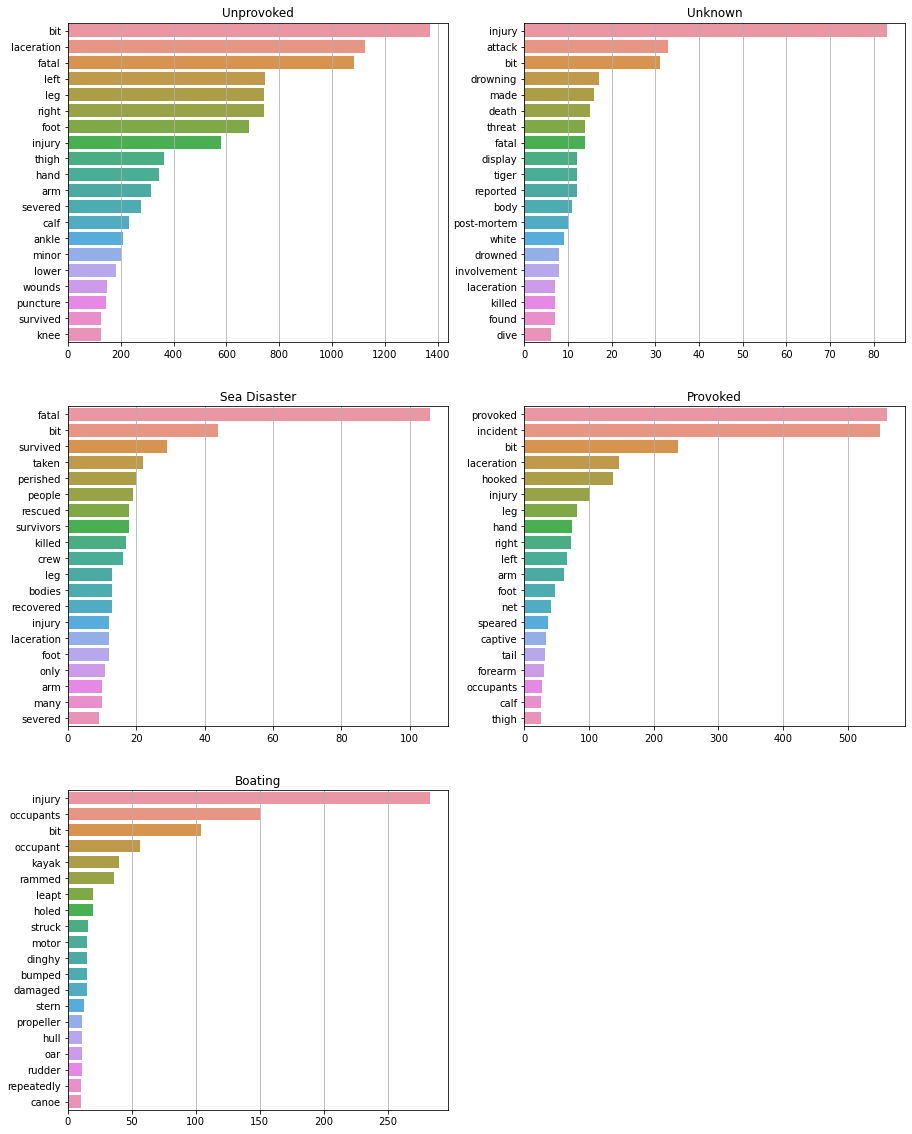

In [21]:
plt.figure(figsize=(15,20))
for i in range(len(types)):
    plt.subplot( len(types)//2+1,len(types)//2, i+1)
    plt.title(types[i])
    dic = word_count_injuries(sharks[sharks["Type"] == types[i]]["Injury"])
    injury_words = pd.Series( dic ).sort_values(ascending=False)
    plt.grid(True)
    sns.barplot(x=injury_words[:20] ,y=injury_words[:20].index)
plt.show()

## Check with fishing and surfing

Without reading all the activity entries, we have the idea that the majority of the provoked incidents are related to fishing, and that almost all surfing related incidents are unprovoked. We are going to lable the incidents that are related to fishing and surfing and compare ratio to the total.

First we are going to save the total cases frequency for each category of incident.

In [22]:
activity = sharks["Type"].value_counts().sort_values(ascending=False)
activity.sum()

5747

Now we are going to create a column with a True/False value if in the activity report there is a term related to these incidents. This is conducted using Regex and the apply comand from Pandas.

In [23]:
def column_fishing(string):
    #List of terms related to fishing
    fishing = ["fishing","spearfishing","netting","netted","net"]
    try:
        for term in fishing:
            if re.search(term,string.lower()):
                return True
    except:
        return False
    
    return False

def column_surfing(string):
    #List of terms related to fishing
    surfing = ["surfing","surf","surfed"] 
    try:
        for term in surfing:
            if re.search(term,string.lower()):
                return True
    except:
        return False
    
    return False


sharks['Fishing'] = sharks['Activity'].apply(column_fishing)
sharks['Surfing'] = sharks['Activity'].apply(column_surfing)

With the information of these new columns we can compute the fraction of incidents in each category related with fishing or surfing.

As hinted by the word frequency, there are ~60% of provoked cases related with fishing, and in the boating category, more than half of the cases are related with fishing as well. This is expected with the previous findings.

With respect to the surfing cases almost all fall in the unprovoked category (26.5% of the unprovoked incidents are related with surfing).

In [24]:
#Fishing ratio for each category
print("Activity: Fishing")
for total,category in zip(activity,activity.index):
    counted = sharks[(sharks["Type"] == category) & (sharks["Fishing"] == True)]["Fishing"].count()
    print(f"  For the {category} type, there are {round(counted*100/total,2)}% cases.")


print("\n---------------------------\n")

#Surfing ratio for each category
print("Activity: Surfing")    
for total,category in zip(activity,activity.index):
    counted = sharks[(sharks["Type"] == category) & (sharks["Surfing"] == True)]["Surfing"].count()
    print(f"  For the {category} type, there are {round(counted*100/total,2)}% cases.")
  

Activity: Fishing
  For the Unprovoked type, there are 12.83% cases.
  For the Provoked type, there are 59.47% cases.
  For the Boating type, there are 54.01% cases.
  For the Sea Disaster type, there are 5.7% cases.
  For the Unknown type, there are 22.86% cases.

---------------------------

Activity: Surfing
  For the Unprovoked type, there are 26.52% cases.
  For the Provoked type, there are 4.07% cases.
  For the Boating type, there are 0.3% cases.
  For the Sea Disaster type, there are 0.44% cases.
  For the Unknown type, there are 12.57% cases.


Even that, looking at the percentage of cases, and taking into account that the unprovoked category is much larger than the rest, below we show a pie chart of the categories of the surfing incidents with charts.

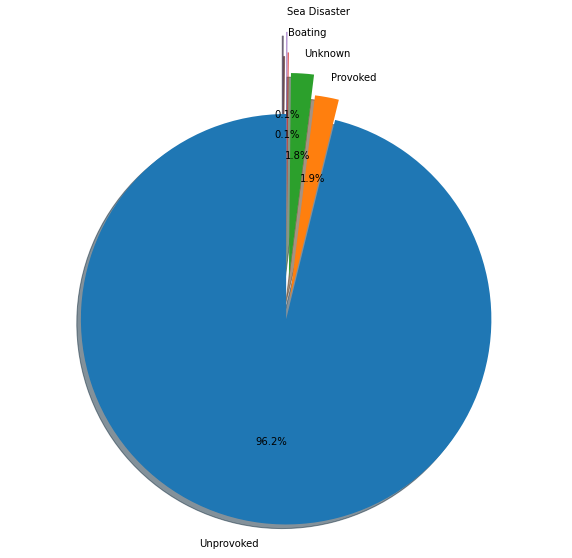

In [25]:
#Computing the percentage of categories related to surfing incidents
type_surf = sharks[sharks["Surfing"] == True]["Type"].value_counts().sort_values(ascending=False)
type_surf_total=type_surf.sum()
type_surf=type_surf*100/type_surf_total


#Pie chart
explode = (0, 0.1,0.2, 0.3, 0.4)  
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(type_surf, explode=explode, labels=type_surf.index, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()